In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from PyT_tinymodels import (OneD_UNet, Dense, LinReg, smoother)
import numpy as np
import matplotlib.pyplot as plt

# Test Training Data Pre-processing

Since I started scaling the input and output vectors by the norm of the input vector (to make the pc scale-invariant), neither the U-Net nor the dense network produce sensible results anymore. Weirdly, both seem to converge fine in both the training and the test dataset, but the MSE on data sampled from the same distribution after training is at least an order of magnitude larger than that at the end of my WandB curves. What is going on? 

In [92]:
device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu"
        )

UNet = OneD_UNet(1,1).to(device)
UNet.load_state_dict(torch.load("/Users/GUSTO/environments/firedrake/src/gusto/learning/unet_poisson.pth"))

dense = Dense().to(device)
dense.load_state_dict(torch.load("/Users/GUSTO/environments/firedrake/src/gusto/learning/poisson.pth"))

linreg = LinReg().to(device)
linreg.load_state_dict(torch.load("/Users/GUSTO/environments/firedrake/src/gusto/learning/lin_poisson.pth"))

Smoother = smoother().to(device)

In [121]:
#generate some training data (solving a 1D discrete Poisson-type linear system)
matrix = (2*np.eye(102) - np.eye(102, k=-1) - np.eye(102, k=1))*100**2

#generate 1000 vectors of size 100, multiply them with matrix to get RHS vectors.
#We want our network to learn the mapping from the RHS vector to the LHS vector
#in a system Ax=b. Here, x:=vec_out, b:=vec_in
#generate x vectors that are smooth and fixed to zero at the boundaries 
#to maintain physicality and allow the network to learn.
xs = np.arange(102, step=1)
a = 0.1 * np.random.randn(1000)
b = 0.05 * np.random.randn(1000)
c = 0.03 * np.random.randn(1000)
d = 0.03 * np.random.randn(1000)
vec_out = np.zeros((1000, 102))
for i in np.arange(1000):
    vec_out[i] = (a[i] * np.sin(np.pi/100 * xs) + b[i] * np.sin(np.pi/100 * 2 * xs) + 
              c[i] * np.sin(np.pi/100 * 3 * xs) + d[i] * np.sin(np.pi/100 * 4 * xs))

#compute RHS based on x vector
vec_in = np.dot(vec_out, matrix)

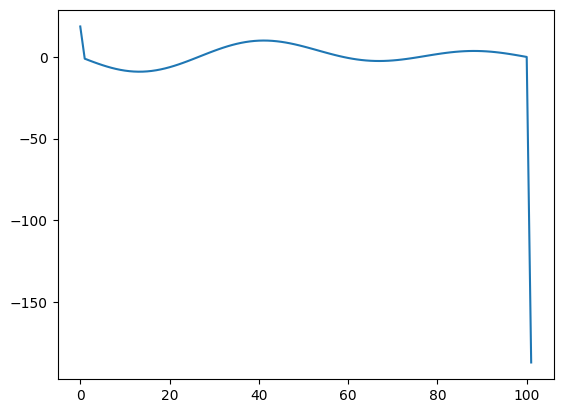

In [126]:
plt.plot(vec_in[0])

In [128]:
2e4 * vec_out[0][-1] - 1e4 * vec_out[0][-2]

-186.90712716935002

In [ ]:
#cut off boundaries because they seem to behave weirdly (bcs not properly specified)
vec_in = vec_in[:, 1:-1]
vec_out = vec_out[:, 1:-1]

In [112]:
input_tensors = torch.tensor(vec_in, dtype=torch.float32)
output_tensors = torch.tensor(vec_out, dtype=torch.float32)

# Create a TensorDataset from input and output tensors
dataset = TensorDataset(input_tensors, output_tensors)

# Define the sizes for training and test sets
train_size = int(0.8 * len(dataset))  # 80% of the data for training
validation_size = len(dataset) - train_size  # Remaining 20% for testing

# Use random_split to create training and test sets
training_set, validation_set = random_split(dataset, [train_size, validation_size])

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = DataLoader(training_set, batch_size=100, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=100, shuffle=False)

In [120]:
vec_in.shape

(1000, 100)

In [116]:
len(training_loader.dataset)

800

In [117]:
datadir = '/Users/GUSTO/data/training/'
in_file = datadir + '/vs.csv'
out_file = datadir + '/ps.csv'

ps = np.loadtxt(out_file, delimiter=',')
vs = np.loadtxt(in_file, delimiter=',')

# Convert data to PyTorch tensors
input_tensors = torch.tensor(vs, dtype=torch.float32)
output_tensors = torch.tensor(ps, dtype=torch.float32)

# Create a TensorDataset from input and output tensors
dataset = TensorDataset(input_tensors, output_tensors)

# Define the sizes for training and test sets
train_size = int(0.8 * len(dataset))  # 80% of the data for training
validation_size = len(dataset) - train_size  # Remaining 20% for testing

# Use random_split to create training and test sets
training_set, validation_set = random_split(dataset, [train_size, validation_size])

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = DataLoader(training_set, batch_size=100, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=100, shuffle=False)

In [118]:
len(training_loader.dataset)

8000

In [119]:
vs.shape

(10000, 100)

To test the preconditioning setup, also define a Jacobi preconditioner which should just work:

In [ ]:
def Jacobi(r):
    D = np.diag(Lapl)
    # LU = Lapl - D
    e = r / D
    return e

In [105]:
norm = np.linalg.norm(vec_in, axis = 1, keepdims = True)
vec_in_scaled = vec_in * 10/norm
vec_out_scaled = vec_out * 10/norm

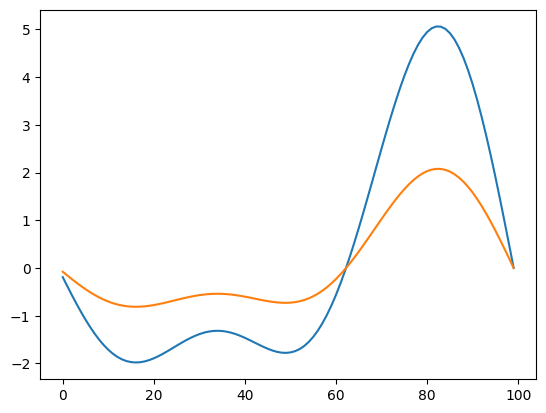

In [106]:
plt.plot(vec_in[0])
plt.plot(vec_in_scaled[0])

In [96]:
Lapl = (2*np.eye(100) - np.eye(100, k=-1) - np.eye(100, k=1))*100**2

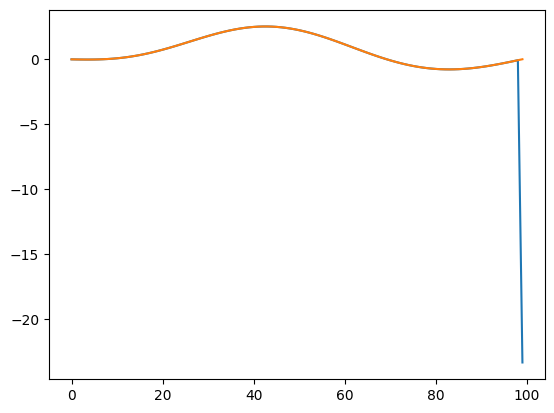

In [97]:
s=5

plt.plot(Lapl@vec_out[s])
plt.plot(vec_in_scaled[s]*norm[s]/10)

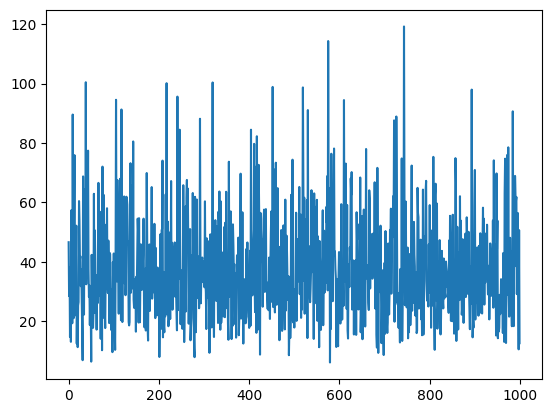

In [98]:
plt.plot(norm)

In [99]:
norm.shape

(1000, 1)

In [100]:
np.linalg.norm(vec_out_scaled, axis = 1, keepdims=True)

array([[0.10406213],
       [0.34008486],
       [0.18248446],
       [0.33219428],
       [0.2159639 ],
       [0.77563032],
       [0.12218458],
       [0.15323661],
       [0.58074649],
       [0.13232515],
       [0.19383058],
       [0.22430011],
       [0.13277107],
       [0.18519174],
       [0.21665213],
       [0.21586227],
       [0.20210154],
       [0.14383914],
       [0.59588906],
       [0.16958692],
       [0.16916998],
       [0.11312667],
       [0.42178667],
       [0.11998268],
       [0.12765547],
       [0.18003697],
       [0.10850459],
       [0.3801802 ],
       [0.19049573],
       [0.40138549],
       [0.45504252],
       [0.83352093],
       [0.11566904],
       [0.15088527],
       [0.83877487],
       [0.10484119],
       [0.11817723],
       [0.0764518 ],
       [0.13690929],
       [0.15038197],
       [0.1856719 ],
       [0.20238305],
       [0.0845898 ],
       [0.15932743],
       [0.16933271],
       [0.17262214],
       [0.13895292],
       [0.123

In [101]:
mse = torch.nn.MSELoss()

MSE: tensor(2.2383e-05)


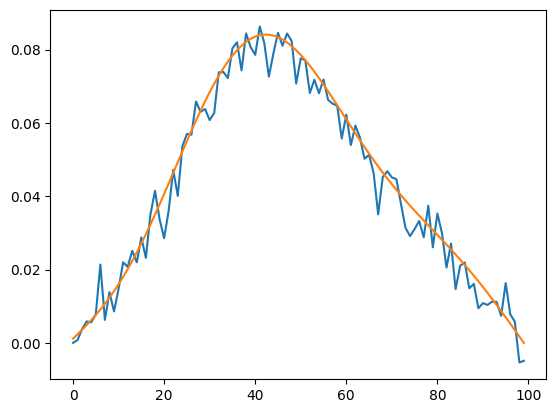

In [102]:
s = 600

tens = torch.tensor(vec_in_scaled[s], dtype=torch.float32)
with torch.no_grad():
    out = dense(tens)
denseout = torch.Tensor.numpy(out)

print('MSE:', str(mse(out, torch.tensor(vec_out_scaled[s], dtype=torch.float32))))

plt.plot(denseout)
plt.plot(vec_out_scaled[s])


MSE: tensor(0.0025)


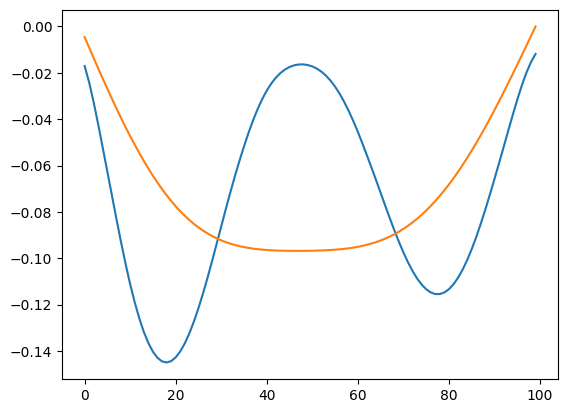

In [103]:
s = 50

tens = torch.tensor(vec_in_scaled[s], dtype=torch.float32)
UNet.eval()
with torch.no_grad():
    tens = tens.unsqueeze(-1)
    tens = tens.unsqueeze(1)
    out = UNet(tens)
    out = out.squeeze()
unetout = torch.Tensor.numpy(out)

print('MSE:', str(mse(out, torch.tensor(vec_out_scaled[s], dtype=torch.float32))))

plt.plot(unetout)
plt.plot(vec_out_scaled[s])
